In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
os.chdir('/content/drive/MyDrive/NLP/Twitter Sentiment Analysis')
!ls

'Twitter Sentiment Analysis.ipynb'   twitter_training.csv   twitter_validation.csv


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,Bidirectional,BatchNormalization
from tensorflow.keras.regularizers import l2
import spacy

In [10]:
df_train = pd.read_csv('twitter_training.csv')

df_test = pd.read_csv('twitter_validation.csv')

In [11]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [13]:
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [14]:
df_test.columns = ['Header1','company','labels','text']
df_train.columns = ['Header1','company','labels','text']

In [15]:
df_train.head()

,Header1,company,labels,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [16]:
df_test.head()

,Header1,company,labels,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [17]:
df_train.shape

(74681, 4)

In [18]:
df_test.shape

(999, 4)

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Header1  74681 non-null  int64 
 1   company  74681 non-null  object
 2   labels   74681 non-null  object
 3   text     73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Header1  999 non-null    int64 
 1   company  999 non-null    object
 2   labels   999 non-null    object
 3   text     999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [21]:
df_train.duplicated().sum()

2700

In [22]:
df_test.duplicated().sum()

0

In [23]:
df_train.isnull().sum()

,0
Header1,0
company,0
labels,0
text,686


In [24]:
df_test.isnull().sum()

,0
Header1,0
company,0
labels,0
text,0


In [25]:
df_train.dropna(inplace=True)

In [26]:
df_train.isnull().sum()

,0
Header1,0
company,0
labels,0
text,0


In [27]:
df_train.drop_duplicates(inplace=True)

In [28]:
df_train.duplicated().sum()

0

In [29]:
df_train.drop(columns=['Header1','company'],inplace=True)

In [30]:
df_test.drop(columns=['Header1','company'],inplace=True)

In [31]:
df_train

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [32]:
df_test

,labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [33]:
def clean_tweet(tweet):
  tweet = re.sub(r'htpp\S+|httpms\S+','',tweet,flags=re.MULTILINE)
  tweet = re.sub(r'\@\w+|\#','',tweet)

  tweet = re.sub(r'\W',' ',tweet)
  tweet = re.sub(r'\d',' ',tweet)
  tweet = re.sub(r'\s+',' ',tweet)
  tweet = tweet.strip()
  return tweet

In [34]:
df_train['text'] = df_train['text'].apply(clean_tweet)
df_test['text'] = df_test['text'].apply(clean_tweet)

In [35]:
df_train.head()

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [36]:
df_test.head()

,labels,text
0,Neutral,BBC News Amazon boss Jeff Bezos rejects claims...
1,Negative,Why do I pay for WORD when it functions so poo...
2,Negative,CSGO matchmaking is so full of closet hacking ...
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi I ve had Madeleine McCann in my cellar for ...


In [37]:
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [38]:
df_train = df_train.dropna(subset=['text'])
df_test = df_test.dropna(subset=['text'])

df_train = df_train[df_train['text'].str.strip() != '']
df_test = df_test[df_test['text'].str.strip() != '']

df_train.head()

,labels,text
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [39]:
df_train.duplicated().sum()

4683

In [40]:
df_train = df_train.drop_duplicates(subset=['text'])

In [41]:
df_train.shape

(66370, 2)

In [42]:
train_texts = df_train['text'].values
train_labels = df_train['labels'].values


test_texts = df_test['text'].values
test_labels = df_test['labels'].values

In [43]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [47]:
train_labels_encoded

array([3, 3, 3, ..., 3, 3, 3])

In [46]:
test_labels_encoded

array([2, 1, 1, 2, 1, 3, 3, 3, 1, 3, 3, 1, 2, 1, 3, 3, 1, 3, 1, 1, 2, 0,
       1, 2, 2, 1, 0, 0, 1, 3, 3, 1, 3, 1, 2, 2, 0, 3, 2, 3, 2, 2, 2, 3,
       2, 1, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 0, 1, 2, 1,
       0, 2, 1, 3, 1, 1, 3, 3, 0, 3, 0, 2, 2, 2, 3, 3, 2, 3, 2, 1, 0, 1,
       2, 2, 1, 3, 0, 0, 1, 1, 1, 2, 3, 2, 1, 3, 3, 2, 3, 2, 3, 1, 2, 2,
       2, 1, 2, 1, 2, 2, 3, 3, 2, 1, 1, 3, 1, 2, 1, 3, 2, 1, 2, 0, 3, 2,
       3, 3, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 3, 2, 3, 0, 3, 1, 2, 2, 2,
       0, 2, 1, 2, 3, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 3, 3, 3, 2, 2, 3, 0,
       2, 2, 2, 3, 2, 1, 1, 2, 3, 3, 0, 0, 2, 3, 3, 2, 0, 2, 1, 1, 1, 1,
       3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 0, 2, 0, 1, 1, 0, 0, 1, 3, 3, 1, 0,
       1, 3, 3, 1, 0, 0, 3, 3, 1, 3, 0, 2, 0, 0, 1, 2, 2, 3, 1, 0, 0, 3,
       3, 0, 0, 2, 3, 1, 1, 3, 3, 3, 3, 2, 2, 3, 1, 2, 3, 2, 1, 2, 2, 1,
       3, 3, 0, 1, 2, 0, 3, 2, 0, 1, 2, 1, 3, 3, 1, 1, 1, 3, 1, 2, 3, 2,
       2, 1, 3, 1, 3, 1, 0, 2, 2, 3, 1, 2, 1, 0, 3,

In [48]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [49]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [50]:
maxlen = max(len(tokens) for tokens in train_sequences)

print('Maximum sequence length (maxlen):',maxlen)

Maximum sequence length (maxlen): 166


In [53]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [54]:
input_size = np.max(train_padded) + 1
input_size

29414

In [55]:
model = Sequential()

model.add(Embedding(input_dim=input_size,output_dim=100,input_shape=(56,)))

model.add(Bidirectional(LSTM(128,kernel_regularizer=l2(0.1),return_sequences=True,recurrent_regularizer=l2(0.1))))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01))))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(64,activation='relu',kernel_regularizer=l2(0.01)))

model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 56, 100)             │       2,941,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 56, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,365 (12.78 MB)

 Trainable params: 3,349,597 (12.78 MB)

 Non-trainable params: 768 (3.00 KB)

In [57]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [58]:
history = model.fit(train_padded,
                    train_labels_encoded,
                    validation_data=(test_padded,test_labels_encoded),
                    epochs = 10
                    )

Epoch 1/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 115s 49ms/step - accuracy: 0.4264 - loss: 8.7372 - val_accuracy: 0.6797 - val_loss: 0.8716
Epoch 2/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 126s 45ms/step - accuracy: 0.7849 - loss: 0.7216 - val_accuracy: 0.7808 - val_loss: 0.6938
Epoch 3/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 124s 37ms/step - accuracy: 0.8428 - loss: 0.5652 - val_accuracy: 0.8378 - val_loss: 0.6096
Epoch 4/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8686 - loss: 0.4970 - val_accuracy: 0.8428 - val_loss: 0.5285
Epoch 5/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 76s 37ms/step - accuracy: 0.8867 - loss: 0.4367 - val_accuracy: 0.6917 - val_loss: 1.1476
Epoch 6/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8972 - loss: 0.3995 - val_accuracy: 0.7598 - val_loss: 0.7687
Epoch 7/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.9067 - loss: 0.3712 - val_accuracy: 0.7387 - val_loss: 1.1112
Epoch 8/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.912

In [61]:
test_loss,test_accuracy = model.evaluate(test_padded,test_labels_encoded)

print(f'Test Loss:{test_loss}')
print(f'Test Accuracy : {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8348 - loss: 0.5397
Test Loss:0.5350667834281921
Test Accuracy : 0.8408408164978027


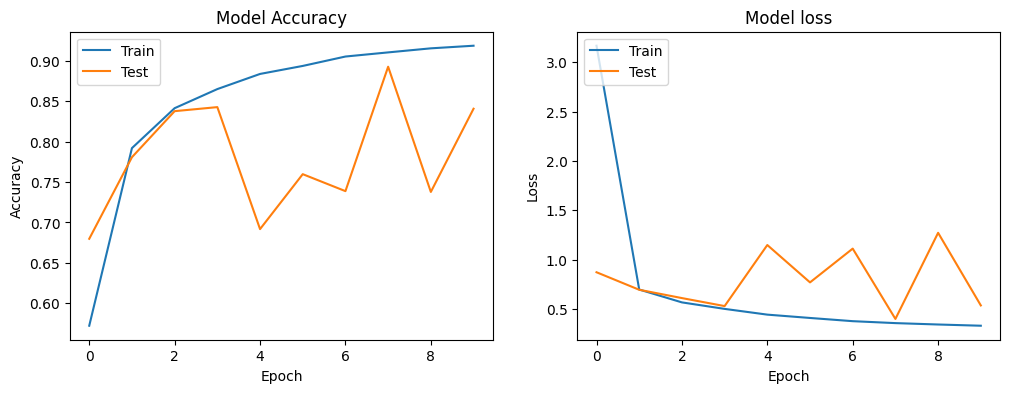

In [62]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')

plt.show()